# Referred from here 
http://benalexkeen.com/gradient-descent-for-linear-regression/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('ggplot')

### We’re going to create a linear regression that follows the distribution:

$y=β0+β1x$

where:

$β0=−50$

$β1=2$

Let’s start by creating some mock data and we’ll graph up this data.

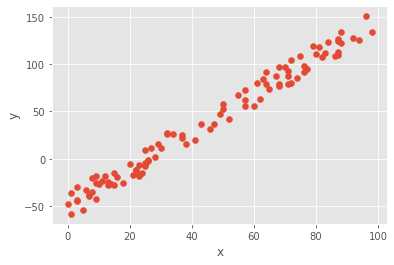

In [2]:
np.random.seed(1)

X = np.random.randint(0, 100, 100)
# Target variable
# y = 2x - 50 + ϵ (noise)
y = 2*X - 50 + np.random.uniform(-15, 15, 100)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

*** Our aim is to minimise the mean of squared errors, calculated as: ***

$MSE=12n∑i=1n(y^i–yi)2$
Where y^ is our prediction of y on the basis of our estimated β0 and β1 values:

y^=β0^+β1^x
and n is our number of observations.

We could just cast a wide net and try lots of values for β0 and β1 and see which gives the lowest value for the MSE.

Let’s give this a go, trying each integer value between -100 and 100 for β0 and β1 and graphing our results:

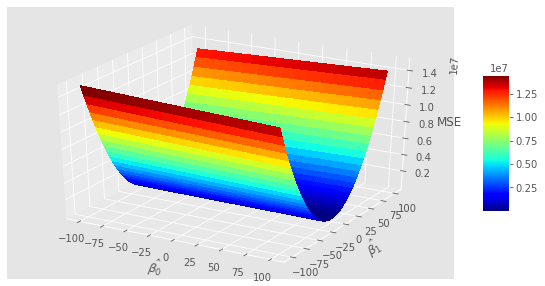

In [3]:
# Try each integer for beta 0 and beta 1 between -100 and 100
beta_0 = beta_1 = np.arange(-100, 100, 1)

# All combinations of beta_0 and beta_1
plt_beta_0, plt_beta_1 = np.meshgrid(beta_0, beta_1)

def calculate_mse(beta_0, beta_1):
    y_hat = beta_0 + beta_1 * X
    error = y_hat - y
    sse = np.sum(error ** 2)
    return ((1 / (2 * len(X))) * sse)

calculate_mse_v = np.vectorize(calculate_mse)
mse = calculate_mse_v(plt_beta_0, plt_beta_1).reshape(len(plt_beta_0), len(plt_beta_1))

fig = plt.figure(figsize=(10, 5))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(plt_beta_0,
                       plt_beta_1,
                       mse,
                       cmap=cm.jet,
                       linewidth=0,
                       antialiased=False)
ax.set_xlabel(r'$\hat{\beta_0}$')
ax.set_ylabel(r'$\hat{\beta_1}$')
ax.set_zlabel(r'MSE')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

As you might expect, varying β1^ has more of a pronounced effect on y than β0^.

We’ll now grab the indexes of our values for β1^ and β0^ for which mse is lowest and graph our results:

y = -51 + 2x


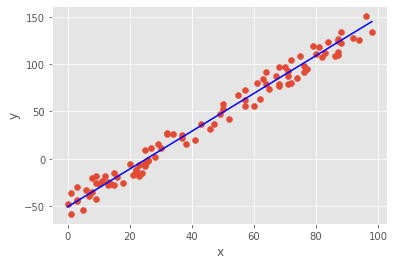

In [4]:
# Get the index for the values of beta_0 and beta_1
# For which SSE is lowest
beta_1_idx, beta_0_idx = np.unravel_index(mse.argmin(), mse.shape)


# Retrieve values of beta_0 and beta_1 for which
# SSE is lowest
beta_0_hat = beta_0[beta_0_idx]
beta_1_hat = beta_1[beta_1_idx]


# Print model parameters
print("y = {} + {}x".format(beta_0_hat, beta_1_hat))


# Plot a line for our model
plt.scatter(X, y)
plt.plot(
    [min(X), max(X)],
    [min(X) * beta_1_hat + beta_0_hat, max(X) * beta_1_hat + beta_0_hat],
    color='blue'
)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Our grid search has done well at approximating β1^ and β0^ for our 1-D feature set.

But this is very inefficient, and quickly becomes slower as you increase granularity and search space.

Instead, we’ll use gradient descent. The aim with gradient descent is to move down a gradient to reach the minimum based on the concave shape given by the cost function as shown in the 3D graph above.

Gradient descent is an iterative process:

1. Initialise β0 and β1 with random values and calculate MSE

2. Calculate the gradient so we move in the direction of minimising MSE

3. Adjust the β0 and β1 with gradient

4. Use new weights to get values for y^ to calculate MSE

Repeat steps 2-4

We use an α term to determine how far down the gradient we should move. An α that is too small will take longer to converge on the minimum, while an α that’s too large can begin to diverge from the minimum value of the MSE.

We will use:

 - α = 0.0005
 - 100,000 iterations.
 - Initialise β0 with a value of 1
 - Initialise β1 with a value of 1
 
We’ll also collect the MSEs as we go along so we can graph our progress afterwards

In [5]:
# Make this an array of arrays with a 
# dummy array of ones for beta_0
X = np.array([np.ones(len(X)), X])
X

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [37., 12., 72.,  9., 75.,  5., 79., 64., 16.,  1., 76., 71.,  6.,
        25., 50., 20., 18., 84., 11., 28., 29., 14., 50., 68., 87., 87.,
        94., 96., 86., 13.,  9.,  7., 63., 61., 22., 57.,  1.,  0., 60.,
        81.,  8., 88., 13., 47., 72., 30., 71.,  3., 70., 21., 49., 57.,
         3., 68., 24., 43., 76., 26., 52., 80., 41., 82., 15., 64., 68.,
        25., 98., 87.,  7., 26., 25., 22.,  9., 67., 23., 27., 37., 57

In [6]:
alpha = 0.0005
iterations = 100000
beta_0_hat = 1
beta_1_hat = 1
mses = []

for i in range(1, iterations+1):
    y_hat = beta_0_hat * X[0] + beta_1_hat * X[1]
    error = y_hat - y
    sse = np.sum(error ** 2)
    mse = ((1 / (2 * len(X.T))) * sse)
    mses.append(mse)
    
    gradient = np.dot(X, error) / len(X.T)
    beta_0_hat = beta_0_hat - (gradient[0] * alpha)
    beta_1_hat = beta_1_hat - (gradient[1] * alpha)
    
    if i % 10000 == 0:
        print("Iteration {}, MSE={}, β0={}, β1={}".format(
            i, round(mse, 3), round(beta_0_hat, 3), round(beta_1_hat, 3)))

Iteration 10000, MSE=53.152, β0=-38.628, β1=1.791
Iteration 20000, MSE=34.885, β0=-47.416, β1=1.929
Iteration 30000, MSE=33.986, β0=-49.364, β1=1.959
Iteration 40000, MSE=33.942, β0=-49.796, β1=1.966
Iteration 50000, MSE=33.94, β0=-49.892, β1=1.967
Iteration 60000, MSE=33.94, β0=-49.913, β1=1.968
Iteration 70000, MSE=33.94, β0=-49.918, β1=1.968
Iteration 80000, MSE=33.94, β0=-49.919, β1=1.968
Iteration 90000, MSE=33.94, β0=-49.919, β1=1.968
Iteration 100000, MSE=33.94, β0=-49.919, β1=1.968


### So our final β0^ value is -49.919 and our final β1^ value is 1.968.

Let’s take a look how this looks when plotted

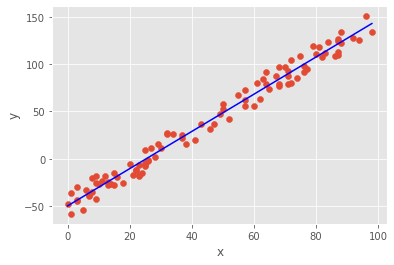

In [7]:
plt.scatter(X[1], y)
plt.plot(
    [min(X[1]), max(X[1])],
    [min(X[1]) * beta_1_hat + beta_0_hat, max(X[1]) * beta_1_hat + beta_0_hat],
    color='blue'
)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### As we collected the MSE values as we iterated through the gradient descent steps, we can graph this and see how the MSE decays over time:

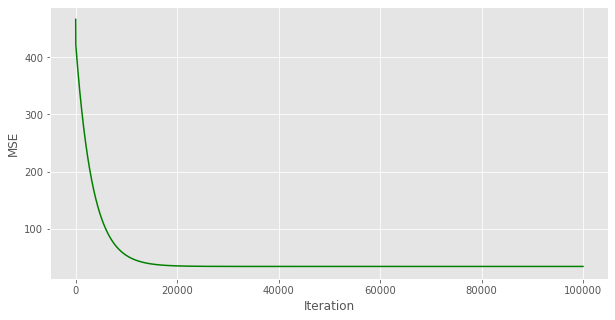

In [9]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, iterations+1), mses, color='green')
plt.ylabel("MSE")
plt.xlabel("Iteration")
plt.show()